Connected to .venv (Python 3.10.7)

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

2024-12-12 23:21:50.259307: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 23:21:50.280425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 23:21:50.280445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 23:21:50.281112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:21:50.284813: I tensorflow/core/platform/cpu_feature_guar

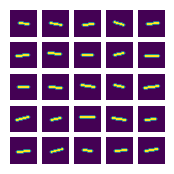

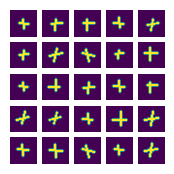

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #1706

X_text: " 8+53" = y_text: " 61"


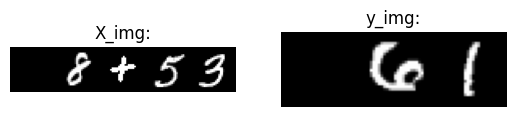

Query #6581

X_text: "32-90" = y_text: "-58"


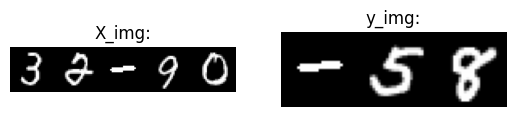

Query #8565

X_text: "42-82" = y_text: "-40"


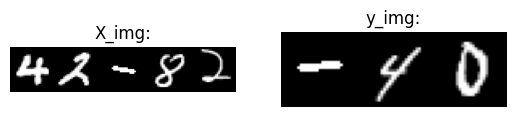

Query #7156

X_text: "35+78" = y_text: "113"


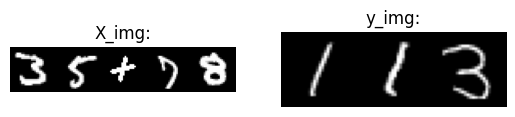

Query #6579

X_text: "32-89" = y_text: "-57"


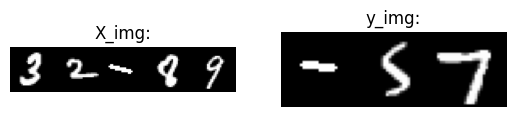

Query #5609

X_text: " 28-4" = y_text: " 24"


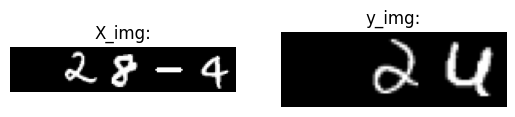

Query #2834

X_text: "14+17" = y_text: " 31"


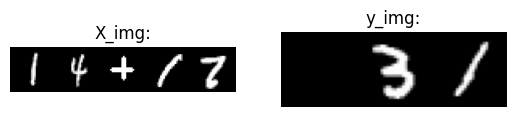

Query #173

X_text: " 0-86" = y_text: "-86"


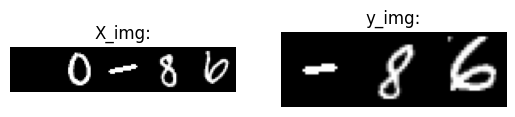

Query #8116

X_text: "40+58" = y_text: " 98"


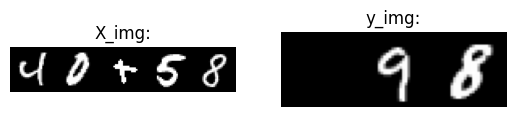

Query #7355

X_text: "36-77" = y_text: "-41"


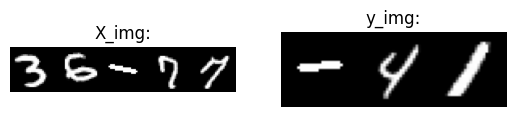

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ## I. Text-to-text RNN model

 The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

 1. LSTM

 2. TimeDistributed

 3. RepeatVector

 The code cell below explains each of these new components.

 <img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. 
    # Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

TRAIN, VALID, TEST Percentage 80.0 10.0 10.0
53+25
 78


2024-12-12 23:21:55.890456: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:21:55.912200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:21:55.912309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 13)             3341      
 ributed)                                                        
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-12-12 23:21:57.099801: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-12 23:21:57.152878: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:21:57.268580: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:21:57.269125: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:21:57.269142: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:21:57.269542: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kern

  1/500 [..............................] - ETA: 15:02 - loss: 2.5657 - accuracy: 0.0938

2024-12-12 23:21:57.899940: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9276e69070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-12 23:21:57.899957: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-12 23:21:57.902694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734042117.932556 1914188 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 6s 9ms/step - loss: 1.7253 - accuracy: 0.3376 - val_loss: 1.4897 - val_accuracy: 0.4110
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 1.3047 - accuracy: 0.4874 - val_loss: 1.1324 - val_accuracy: 0.5613
Epoch 3/50
500/500 [==============================] - 4s 9ms/step - loss: 1.0931 - accuracy: 0.5721 - val_loss: 1.0422 - val_accuracy: 0.5912
Epoch 4/50
500/500 [==============================] - 4s 8ms/step - loss: 1.0132 - accuracy: 0.6025 - val_loss: 0.9658 - val_accuracy: 0.6233
Epoch 5/50
500/500 [==============================] - 4s 8ms/step - loss: 0.9629 - accuracy: 0.6251 - val_loss: 0.9427 - val_accuracy: 0.6332
Epoch 6/50
500/500 [==============================] - 3s 6ms/step - loss: 0.9351 - accuracy: 0.6358 - val_loss: 0.9494 - val_accuracy: 0.6293
Epoch 7/50
500/500 [==============================] - 4s 9ms/step - loss: 0.9164 - accuracy: 0.6414 - val_loss: 0.9017 - val_accuracy: 0.6488
Epoch 8/50
500/50

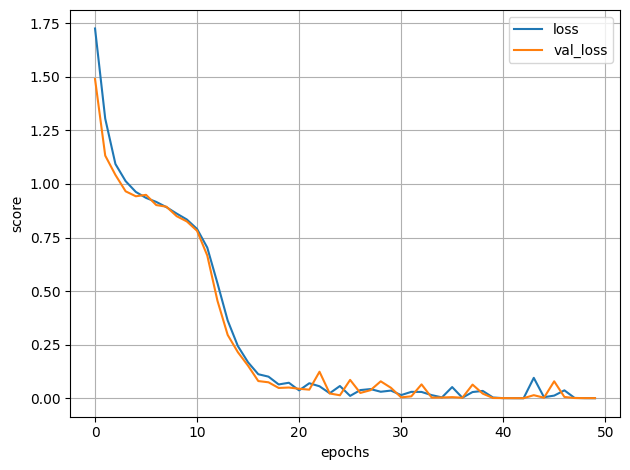

63/63 [==============================] - 0s 1ms/step
Result for TRAIN, VALID, TEST Percentage 80.0 10.0 10.0
500/500 [==============================] - 1s 2ms/step - loss: 7.2255e-04 - accuracy: 1.0000
Train Accuracy for text to text model:  [0.0007225463632494211, 1.0]
63/63 [==============================] - 0s 2ms/step - loss: 9.4567e-04 - accuracy: 1.0000
Test Accuracy for text to text model:  [0.000945674953982234, 1.0]
Test String Accuracy:  1.0
TRAIN, VALID, TEST Percentage 50.0 0.0 50.0
53+25
 78
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_

2024-12-12 23:24:32.863137: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:24:32.863150: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:24:32.863159: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


313/313 [==============================] - 2s 3ms/step - loss: 1.7981 - accuracy: 0.3213
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 1.5135 - accuracy: 0.4105
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 1.2630 - accuracy: 0.5044
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 1.1315 - accuracy: 0.5563
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 1.0560 - accuracy: 0.5857
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 1.0009 - accuracy: 0.6101
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9707 - accuracy: 0.6217
Epoch 8/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9510 - accuracy: 0.6297
Epoch 9/50
313/313 [==============================] - 1s 3ms/step - loss: 0.9253 - accuracy: 0.6408
Epoch 10/50
313/313 [==============================] - 1s 3ms/step - loss: 0.9114 - accuracy: 0.6472
Epoch 11/5

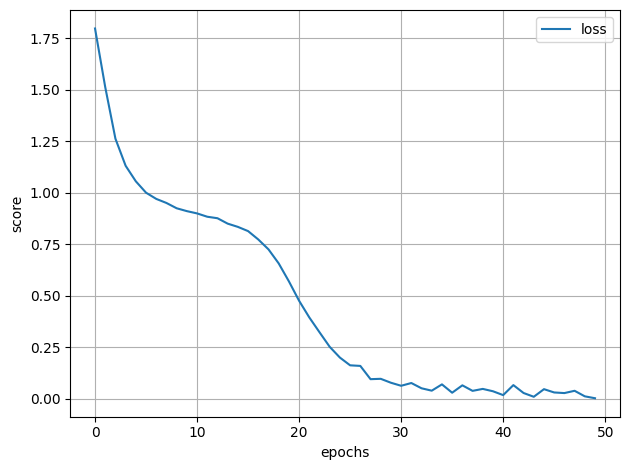

313/313 [==============================] - 1s 2ms/step
Result for TRAIN, VALID, TEST Percentage 50.0 0.0 50.0
313/313 [==============================] - 1s 3ms/step - loss: 0.0021 - accuracy: 1.0000
Train Accuracy for text to text model:  [0.0021463236771523952, 0.9999666810035706]
313/313 [==============================] - 1s 3ms/step - loss: 0.0051 - accuracy: 0.9992
Test Accuracy for text to text model:  [0.005132595077157021, 0.9991666674613953]
Test String Accuracy:  0.9975
TRAIN, VALID, TEST Percentage 25.0 0.0 75.0
53+25
 78
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                            

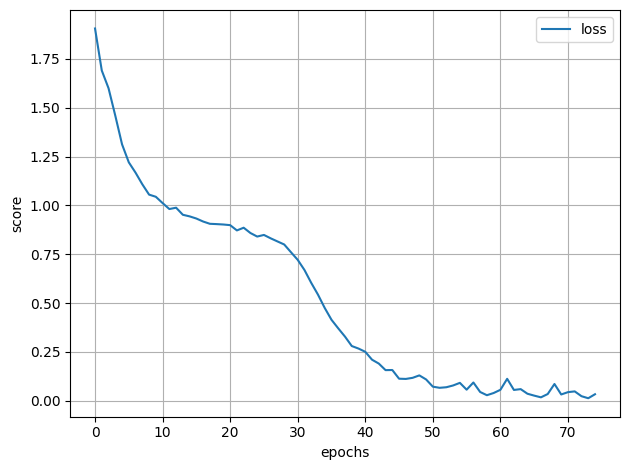

469/469 [==============================] - 1s 2ms/step
Result for TRAIN, VALID, TEST Percentage 25.0 0.0 75.0
157/157 [==============================] - 1s 3ms/step - loss: 0.0682 - accuracy: 0.9757
Train Accuracy for text to text model:  [0.06815770268440247, 0.9757333397865295]
469/469 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9588
Test Accuracy for text to text model:  [0.11405377835035324, 0.9588222503662109]
Test String Accuracy:  0.8835333333333333
TRAIN, VALID, TEST Percentage 10.0 0.0 90.0
53+25
 78
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                   

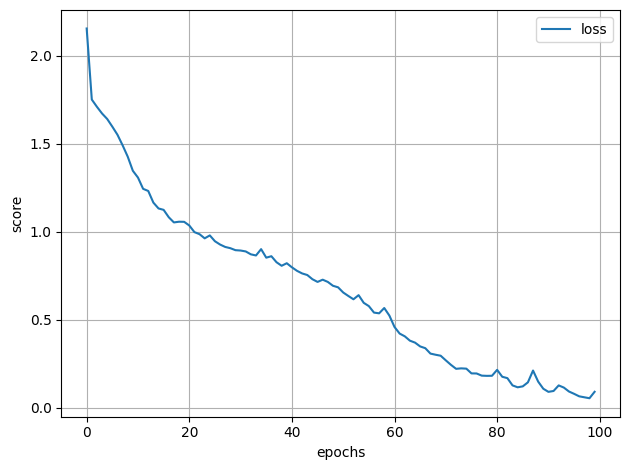

563/563 [==============================] - 1s 2ms/step
Result for TRAIN, VALID, TEST Percentage 10.0 0.0 90.0
63/63 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.9775
Train Accuracy for text to text model:  [0.09855355322360992, 0.9775000214576721]
563/563 [==============================] - 1s 3ms/step - loss: 0.5863 - accuracy: 0.8079
Test Accuracy for text to text model:  [0.5863106846809387, 0.8079259395599365]
Test String Accuracy:  0.49894444444444447


In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
##( Your first task is to fit the text2text model using X_text and y_text)
import tensorflow.keras as keras # type: ignore
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


data_percentage = [[80.0, 10.0, 10.0, 50], [50.0, 0.0, 50.0, 50], [25.0, 0.0, 75.0, 75], [10.0, 0.0, 90.0, 100]]
models=[]
for each in data_percentage:
    print("TRAIN, VALID, TEST Percentage", each[0], each[1], each[2])
    X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, 
                                                        test_size=(each[1]+each[2])/100.0, random_state=42) 

    
    print(decode_labels(X_test[0]))
    print(decode_labels(y_test[0]))
    # Fit the model
    model = build_text2text_model()
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            f"text_to_text_best.keras", save_best_only=True
        )
    
    if each[1]:
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, 
                                                            test_size=each[1]/(each[1]+each[2]), random_state=42) 
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # metric to monitor
            patience=10,          # number of epochs to wait for improvement
            restore_best_weights=True  # restore the best weights after stopping
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            batch_size=32,
            epochs=50,
            callbacks=[checkpoint_cb, early_stopping],
        )
    else:
        history = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=each[-1],
            callbacks=[checkpoint_cb]
        )
    model.save(f'submission1_text_to_text.keras')

    data_history = pd.DataFrame(history.history)
    data_history.to_csv('text_to_text_history.csv')
    
    plt.plot(history.history['loss'], label='loss')
    if each[1]:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend(loc="best")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    predictions = model.predict(X_test)
    y_pred = [decode_labels(y) for y in predictions]
    y_actual = [decode_labels(y) for y in y_test]

    accuracy = accuracy_score(y_actual, y_pred)
    print("Result for TRAIN, VALID, TEST Percentage", each[0], each[1], each[2])
    print("Train Accuracy for text to text model: ", model.evaluate(X_train, y_train))
    print("Test Accuracy for text to text model: ", model.evaluate(X_test, y_test))
    print("Test String Accuracy: ", accuracy)

    #to clear cache
    models.append(model)
    continue
    import gc

    # Delete unnecessary variables
    del model

    # Force garbage collection
    gc.collect()

In [ ]:
# TODO check that we get correct results -> done
preds = [list(map(decode_labels,m.predict(X_test))) for m in models]
trues = list(map(decode_labels,y_test))
scores = [accuracy_score(trues,i) for i in preds+[trues]]
evals = [m.evaluate(X_test,y_test)[1] for m in models] + [1]

563/563 [==============================] - 1s 3ms/step - loss: 0.5863 - accuracy: 0.8079


<Axes: xlabel='10.0,0.0,90.0,100', ylabel='true'>

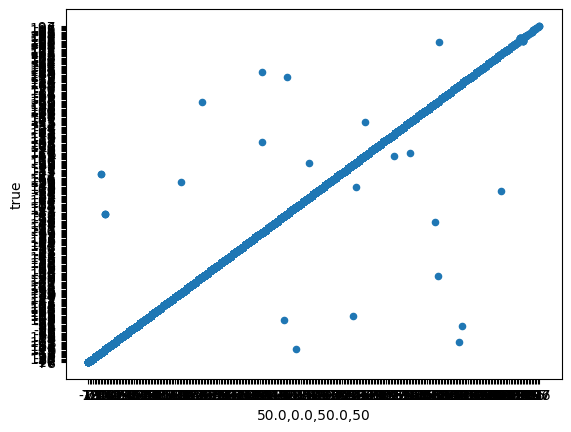

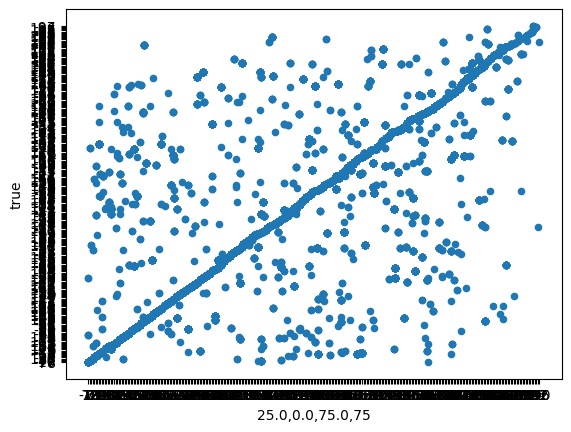

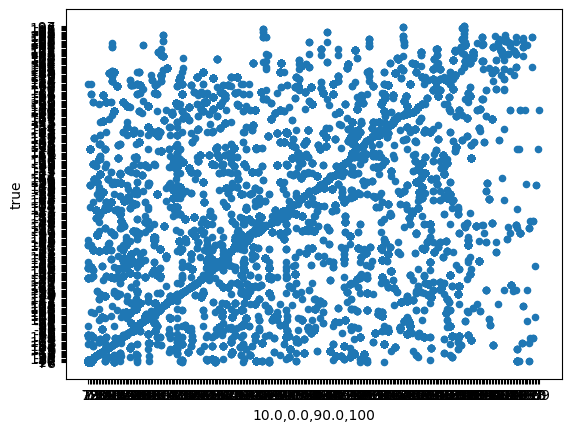

In [ ]:
# TODO when do we get a decreased accuracy and why
# entire output numbers
columns = [",".join([str(i) for i in l]) for l in data_percentage] + ['true']
score_df = pd.DataFrame([scores,evals])
score_df.index=["test_string_accuracy","test_character_accuracy"]
score_df.columns = columns
df = pd.DataFrame(preds+[trues]).T
df.columns = columns
df.plot.scatter(columns[1],columns[-1])
df.plot.scatter(columns[2],columns[-1])
df.plot.scatter(columns[3],columns[-1])

<Axes: xlabel='80.0,10.0,10.0,50', ylabel='true'>

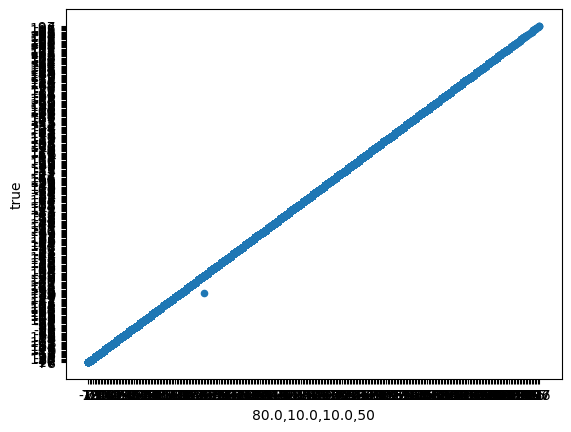

In [ ]:
df.plot.scatter(columns[0],columns[-1])

<ipython-input-11-22c747a5cc4e>:28: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


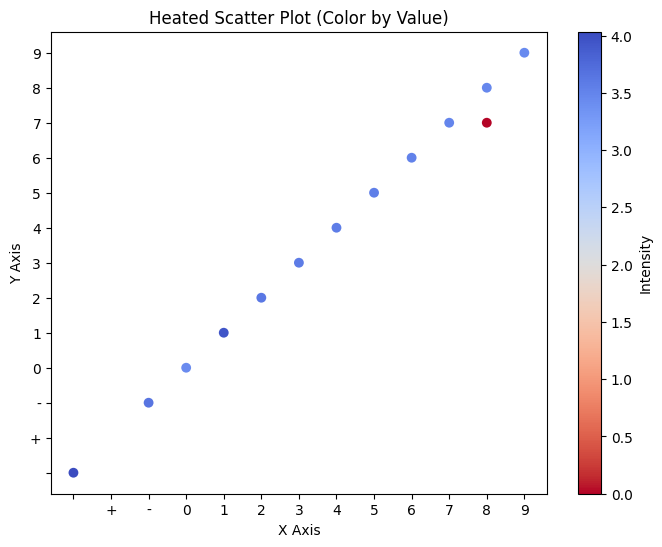

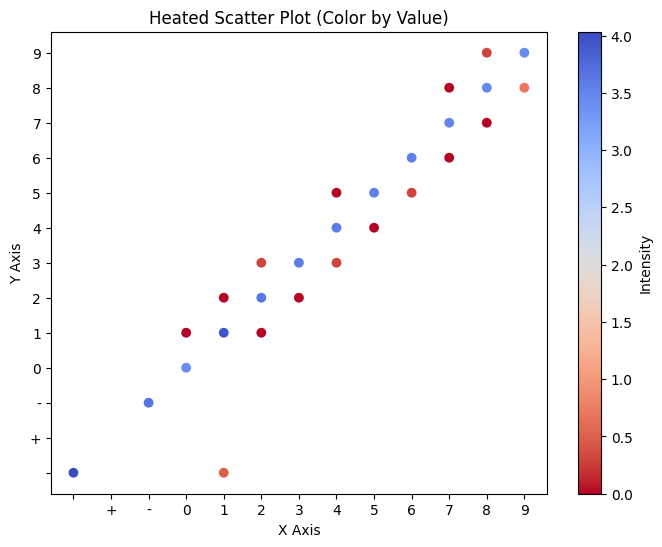

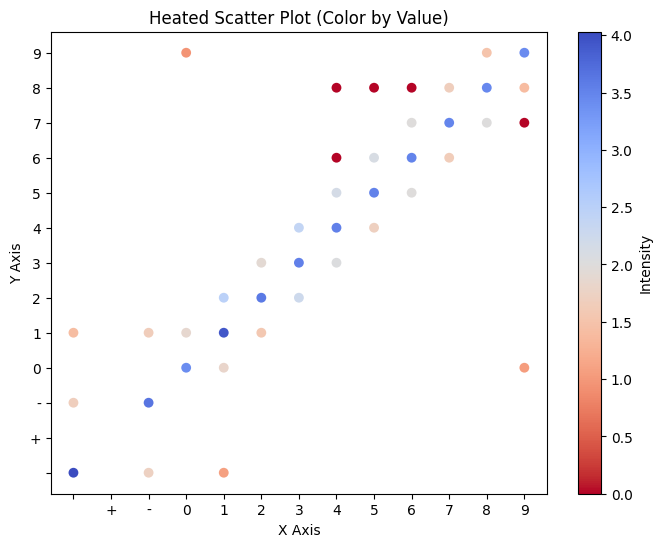

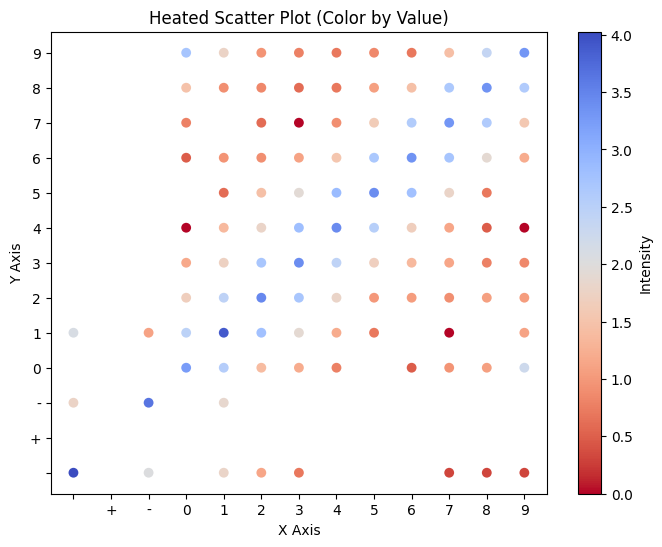

: 

In [ ]:
# symbol by symbol
wrong_positions = [np.argwhere(np.array(p)!=trues) for p in preds]
# TODO visualize the differences perhaps scatterplot
#find out what kind of mistakes your models make on the misclassified samples.
wrong_data = [X_test[pos] for pos in wrong_positions]

# decoded_wrong_inputs = [[list(map(decode_labels,data)) for data in model_wrong_data] for model_wrong_data in wrong_data]
wrong_outputs = [np.array(p)[idx] for idx,p in zip(wrong_positions,preds)]
wrong_out_characters = ["".join([str(i) for i in w.ravel()]) for w in wrong_outputs]
correct_characters = ["".join([str(i) for i in np.array(trues)[idx].ravel()]) for idx in wrong_positions ]

pred_characters = ["".join([str(i) for i in y]) for y in preds]
true_characters = "".join([str(char) for y in trues for char in y])
mapping = {i:n for i,n in zip(unique_characters,range(len(unique_characters)))}

from collections import Counter
counts = [Counter([(true,pred) for true,pred in zip(true_characters,chars)]) for chars in pred_characters]


for i in range(len(models)):
    x=[each[0] for each in counts[i].keys()]
    y=[each[1] for each in counts[i].keys()]
    z=[each for each in counts[i].values()]
    l = list(zip(x,y,z))
    l = sorted([(i,i,0) for i in unique_characters]) + l
    x,y,z = [i[0] for i in l],[i[1] for i in l],[i[2] for i in l]
    z = np.log10(z)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(x, y, c=z, cmap='coolwarm_r', s=50, edgecolor='none')
    plt.colorbar(sc, label='Intensity')
    plt.title("Heated Scatter Plot (Color by Value)")
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.show()